In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import warnings
import time
import psutil
from joblib import Parallel, delayed
import gc
from scipy.spatial.distance import cdist  # KNN için mesafe matrisleri

warnings.filterwarnings('ignore')

# Checkpoint fonksiyonu
def print_checkpoint(message):
    ram_usage = psutil.virtual_memory().percent
    ram_used_gb = psutil.virtual_memory().used / (1024 ** 3)  # GB cinsinden
    print(f"[CHECKPOINT {time.strftime('%H:%M:%S')}] {message} | RAM Kullanımı: {ram_usage}% ({ram_used_gb:.2f} GB)")

# RAM'i doldurmak için büyük veri kopyaları
def create_data_copies(X, y, n_copies=100000):  # 100,000 kopya ~100 GB
    print_checkpoint(f"{n_copies} veri kopyası oluşturuluyor...")
    copies = [(X.copy(), y.copy()) for _ in range(n_copies)]
    print_checkpoint("Veri kopyaları oluşturuldu.")
    return copies

# KNN için mesafe matrisleri (RAM yoğun)
def compute_distance_matrices(X, metric='euclidean', n_matrices=100):
    print_checkpoint(f"{n_matrices} mesafe matrisi hesaplanıyor...")
    matrices = [cdist(X, X, metric=metric) for _ in range(n_matrices)]
    print_checkpoint("Mesafe matrisleri hesaplandı.")
    return matrices

# 1. Veri Setini Yükleme
print_checkpoint("Veri seti yükleniyor...")
data = pd.read_csv('/content/drive/MyDrive/ÖrüntüDers/diabetes_new.csv')
print_checkpoint("Veri seti yüklendi.")

# Veri tiplerini float64/int64 tutarak RAM kullanımını artır
print_checkpoint("Veri tipleri ayarlanıyor...")
for col in data.select_dtypes(include=['int32', 'int64']).columns:
    data[col] = data[col].astype('int64')
for col in data.select_dtypes(include=['float32', 'float64']).columns:
    data[col] = data[col].astype('float64')
print_checkpoint("Veri tipleri ayarlandı.")

# Unnamed: 0 sütununu kaldırma
print_checkpoint("Unnamed: 0 sütunu kaldırılıyor...")
data = data.drop('Unnamed: 0', axis=1)
print_checkpoint("Unnamed: 0 sütunu kaldırıldı.")

# Özellikler ve hedef değişken
print_checkpoint("Özellikler ve hedef değişken ayrılıyor...")
X = data.drop('diabetes', axis=1)
y = data['diabetes'].astype('int64')
print_checkpoint("Özellikler ve hedef ayrıldı.")

# 2. Veriyi Eğitim ve Test Setlerine Ayırma
print_checkpoint("Veri eğitim ve test setlerine bölünüyor...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print_checkpoint("Veri bölündü.")

# 3. Veriyi Ölçeklendirme
print_checkpoint("Veri ölçeklendiriliyor...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype('float64')  # float64 için daha fazla RAM
X_test_scaled = scaler.transform(X_test).astype('float64')
print_checkpoint("Veri ölçeklendirildi.")

# RAM'i doldurmak için işlemler
print_checkpoint("RAM doldurma işlemleri başlatılıyor...")
data_copies = create_data_copies(X_train_scaled, y_train, n_copies=100000)  # ~100 GB
distance_matrices = compute_distance_matrices(X_train_scaled, n_matrices=100)  # ~50 GB
print_checkpoint("RAM doldurma işlemleri tamamlandı.")

# 4. KNN ve XGBoost modellerini paralel çalıştırma
def train_knn(X_train, y_train, scoring, name):
    print_checkpoint(f"KNN için {name} RandomizedSearch başlatılıyor...")
    knn = KNeighborsClassifier()
    knn_param_grid = {
        'n_neighbors': [3, 5, 7, 11, 25, 50, 100, 150, 200],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [20, 30, 40],
        'p': [1, 2],
        'metric': ['euclidean', 'manhattan', 'chebyshev'],
        'n_jobs': [-1]
    }
    random_search = RandomizedSearchCV(estimator=knn, param_distributions=knn_param_grid,
                                      n_iter=200, cv=5, scoring=scoring, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    print_checkpoint(f"KNN için {name} RandomizedSearch tamamlandı.")
    return random_search

def train_xgb(X_train, y_train, scoring, name):
    print_checkpoint(f"XGBoost için {name} RandomizedSearch başlatılıyor...")
    xgb = XGBClassifier(use_label_encoder=False)
    xgb_param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 9],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'colsample_bylevel': [0.6, 1.0],
        'colsample_bynode': [0.6, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 2],
        'scale_pos_weight': [1, 2],
        'base_score': [0.5],
        'booster': ['gbtree', 'dart'],
        'num_parallel_tree': [1],
        'random_state': [42],
        'objective': ['binary:logistic'],
        'eval_metric': ['logloss'],
        'verbosity': [0],
        'tree_method': ['auto', 'hist'],
        'grow_policy': ['depthwise', 'lossguide'],
        'max_leaves': [0, 10],
        'max_bin': [256, 512],
        'device': ['cpu']
    }
    random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid,
                                      n_iter=200, cv=5, scoring=scoring, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    print_checkpoint(f"XGBoost için {name} RandomizedSearch tamamlandı.")
    return random_search

# Paralel model eğitimi
print_checkpoint("KNN ve XGBoost modelleri paralel başlatılıyor...")
results = Parallel(n_jobs=-1)(
    delayed(func)(X_train_scaled, y_train, scoring, name)
    for func, scoring, name in [
        (train_knn, 'accuracy', 'Accuracy KNN'),
        (train_knn, 'f1', 'F1 KNN'),
        (train_xgb, 'accuracy', 'Accuracy XGBoost'),
        (train_xgb, 'f1', 'F1 XGBoost')
    ]
)
print_checkpoint("Paralel eğitim tamamlandı.")

# Sonuçları ayırma
knn_random_acc, knn_random_f1, xgb_random_acc, xgb_random_f1 = results

# 5. Sonuçları Yazdırma
print_checkpoint("Sonuçlar yazdırılıyor...")
print("\nKNN - Accuracy için En İyi Parametreler:", knn_random_acc.best_params_)
print("KNN - Accuracy için En İyi Skor:", knn_random_acc.best_score_)
print("KNN - F1 için En İyi Parametreler:", knn_random_f1.best_params_)
print("KNN - F1 için En İyi Skor:", knn_random_f1.best_score_)

print("\nXGBoost - Accuracy için En İyi Parametreler:", xgb_random_acc.best_params_)
print("XGBoost - Accuracy için En İyi Skor:", xgb_random_acc.best_score_)
print("XGBoost - F1 için En İyi Parametreler:", xgb_random_f1.best_params_)
print("XGBoost - F1 için En İyi Skor:", xgb_random_f1.best_score_)

# Test seti üzerinde tahminler
print_checkpoint("KNN Accuracy modeli test setinde değerlendiriliyor...")
knn_best_acc = knn_random_acc.best_estimator_
y_pred_knn_acc = knn_best_acc.predict(X_test_scaled)
print("\nKNN - Test Seti Doğruluğu (Accuracy Modeli):", accuracy_score(y_test, y_pred_knn_acc))
print("KNN - Test Seti Sınıflandırma Raporu (Accuracy Modeli):\n", classification_report(y_test, y_pred_knn_acc))
print_checkpoint("KNN Accuracy testi tamamlandı.")

print_checkpoint("KNN F1 modeli test setinde değerlendiriliyor...")
knn_best_f1 = knn_random_f1.best_estimator_
y_pred_knn_f1 = knn_best_f1.predict(X_test_scaled)
print("\nKNN - Test Seti Doğruluğu (F1 Modeli):", accuracy_score(y_test, y_pred_knn_f1))
print("KNN - Test Seti Sınıflandırma Raporu (F1 Modeli):\n", classification_report(y_test, y_pred_knn_f1))
print_checkpoint("KNN F1 testi tamamlandı.")

print_checkpoint("XGBoost Accuracy modeli test setinde değerlendiriliyor...")
xgb_best_acc = xgb_random_acc.best_estimator_
y_pred_xgb_acc = xgb_best_acc.predict(X_test_scaled)
print("\nXGBoost - Test Seti Doğruluğu (Accuracy Modeli):", accuracy_score(y_test, y_pred_xgb_acc))
print("XGBoost - Test Seti Sınıflandırma Raporu (Accuracy Modeli):\n", classification_report(y_test, y_pred_xgb_acc))
print_checkpoint("XGBoost Accuracy testi tamamlandı.")

print_checkpoint("XGBoost F1 modeli test setinde değerlendiriliyor...")
xgb_best_f1 = xgb_random_f1.best_estimator_
y_pred_xgb_f1 = xgb_best_f1.predict(X_test_scaled)
print("\nXGBoost - Test Seti Doğruluğu (F1 Modeli):", accuracy_score(y_test, y_pred_xgb_f1))
print("XGBoost - Test Seti Sınıflandırma Raporu (F1 Modeli):\n", classification_report(y_test, y_pred_xgb_f1))
print_checkpoint("XGBoost F1 testi tamamlandı.")

# RAM temizleme
print_checkpoint("RAM temizleniyor...")
data_copies = None
distance_matrices = None
gc.collect()
print_checkpoint("RAM temizlendi.")

print_checkpoint("Kod tamamlandı!")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
[CHECKPOINT 13:27:07] Veri seti yükleniyor... | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Veri seti yüklendi. | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Veri tipleri ayarlanıyor... | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Veri tipleri ayarlandı. | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Unnamed: 0 sütunu kaldırılıyor... | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Unnamed: 0 sütunu kaldırıldı. | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Özellikler ve hedef değişken ayrılıyor... | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Özellikler ve hedef ayrıldı. | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Veri eğitim ve test setlerine bölünüyor... | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Veri bölündü. | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Veri ölçeklendiriliyor... | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] Veri ölçeklendirildi. | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] RAM doldurma işlemleri başlatılıyor... | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:27:07] 100000 veri kopyası oluşturuluyor... | RAM Kullanımı: 1.6% (3.22 GB)
[CHECKPOINT 13:28:13] Veri kopyaları oluşturuldu. | RAM Kullanımı: 28.9% (94.47 GB)
[CHECKPOINT 13:28:13] 100 mesafe matrisi hesaplanıyor... | RAM Kullanımı: 28.9% (94.47 GB)
[CHECKPOINT 13:31:02] Mesafe matrisleri hesaplandı. | RAM Kullanımı: 70.0% (232.00 GB)
[CHECKPOINT 13:31:02] RAM doldurma işlemleri tamamlandı. | RAM Kullanımı: 70.0% (232.00 GB)
[CHECKPOINT 13:31:02] KNN ve XGBoost modelleri paralel başlatılıyor... | RAM Kullanımı: 70.0% (232.00 GB)
[CHECKPOINT 14:03:10] Paralel eğitim tamamlandı. | RAM Kullanımı: 70.1% (232.45 GB)
[CHECKPOINT 14:03:10] Sonuçlar yazdırılıyor... | RAM Kullanımı: 70.1% (232.45 GB)

KNN - Accuracy için En İyi Parametreler: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11, 'n_jobs': -1, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'kd_tree'}
KNN - Accuracy için En İyi Skor: 0.8890853313870469
KNN - F1 için En İyi Parametreler: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11, 'n_jobs': -1, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'kd_tree'}
KNN - F1 için En İyi Skor: 0.8910021043761038

XGBoost - Accuracy için En İyi Parametreler: {'verbosity': 0, 'tree_method': 'hist', 'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 2, 'reg_alpha': 0.1, 'random_state': 42, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 150, 'min_child_weight': 5, 'max_leaves': 10, 'max_depth': 9, 'max_bin': 512, 'learning_rate': 0.1, 'grow_policy': 'depthwise', 'gamma': 0.2, 'eval_metric': 'logloss', 'device': 'cpu', 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 1.0, 'booster': 'dart', 'base_score': 0.5}
XGBoost - Accuracy için En İyi Skor: 0.9131845604870351
XGBoost - F1 için En İyi Parametreler: {'verbosity': 0, 'tree_method': 'hist', 'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 2, 'reg_alpha': 0.1, 'random_state': 42, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 150, 'min_child_weight': 5, 'max_leaves': 10, 'max_depth': 9, 'max_bin': 512, 'learning_rate': 0.1, 'grow_policy': 'depthwise', 'gamma': 0.2, 'eval_metric': 'logloss', 'device': 'cpu', 'colsample_bytree': 1.0, 'colsample_bynode': 0.6, 'colsample_bylevel': 1.0, 'booster': 'dart', 'base_score': 0.5}
XGBoost - F1 için En İyi Skor: 0.9145429057867631
[CHECKPOINT 14:03:10] KNN Accuracy modeli test setinde değerlendiriliyor... | RAM Kullanımı: 70.1% (232.45 GB)

KNN - Test Seti Doğruluğu (Accuracy Modeli): 0.8862363689949897
KNN - Test Seti Sınıflandırma Raporu (Accuracy Modeli):
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1714
           1       0.88      0.89      0.89      1679

    accuracy                           0.89      3393
   macro avg       0.89      0.89      0.89      3393
weighted avg       0.89      0.89      0.89      3393

[CHECKPOINT 14:03:11] KNN Accuracy testi tamamlandı. | RAM Kullanımı: 70.1% (232.45 GB)
[CHECKPOINT 14:03:11] KNN F1 modeli test setinde değerlendiriliyor... | RAM Kullanımı: 70.1% (232.45 GB)

KNN - Test Seti Doğruluğu (F1 Modeli): 0.8862363689949897
KNN - Test Seti Sınıflandırma Raporu (F1 Modeli):
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1714
           1       0.88      0.89      0.89      1679

    accuracy                           0.89      3393
   macro avg       0.89      0.89      0.89      3393
weighted avg       0.89      0.89      0.89      3393

[CHECKPOINT 14:03:11] KNN F1 testi tamamlandı. | RAM Kullanımı: 70.1% (232.45 GB)
[CHECKPOINT 14:03:11] XGBoost Accuracy modeli test setinde değerlendiriliyor... | RAM Kullanımı: 70.1% (232.45 GB)

XGBoost - Test Seti Doğruluğu (Accuracy Modeli): 0.9083407014441497
XGBoost - Test Seti Sınıflandırma Raporu (Accuracy Modeli):
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1714
           1       0.90      0.91      0.91      1679

    accuracy                           0.91      3393
   macro avg       0.91      0.91      0.91      3393
weighted avg       0.91      0.91      0.91      3393

[CHECKPOINT 14:03:11] XGBoost Accuracy testi tamamlandı. | RAM Kullanımı: 70.1% (232.45 GB)
[CHECKPOINT 14:03:11] XGBoost F1 modeli test setinde değerlendiriliyor... | RAM Kullanımı: 70.1% (232.45 GB)

XGBoost - Test Seti Doğruluğu (F1 Modeli): 0.9083407014441497
XGBoost - Test Seti Sınıflandırma Raporu (F1 Modeli):
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1714
           1       0.90      0.91      0.91      1679

    accuracy                           0.91      3393
   macro avg       0.91      0.91      0.91      3393
weighted avg       0.91      0.91      0.91      3393

[CHECKPOINT 14:03:11] XGBoost F1 testi tamamlandı. | RAM Kullanımı: 70.1% (232.45 GB)
[CHECKPOINT 14:03:11] RAM temizleniyor... | RAM Kullanımı: 70.1% (232.45 GB)
[CHECKPOINT 14:03:13] RAM temizlendi. | RAM Kullanımı: 70.1% (232.46 GB)
[CHECKPOINT 14:03:13] Kod tamamlandı! | RAM Kullanımı: 29.1% (95.01 GB)

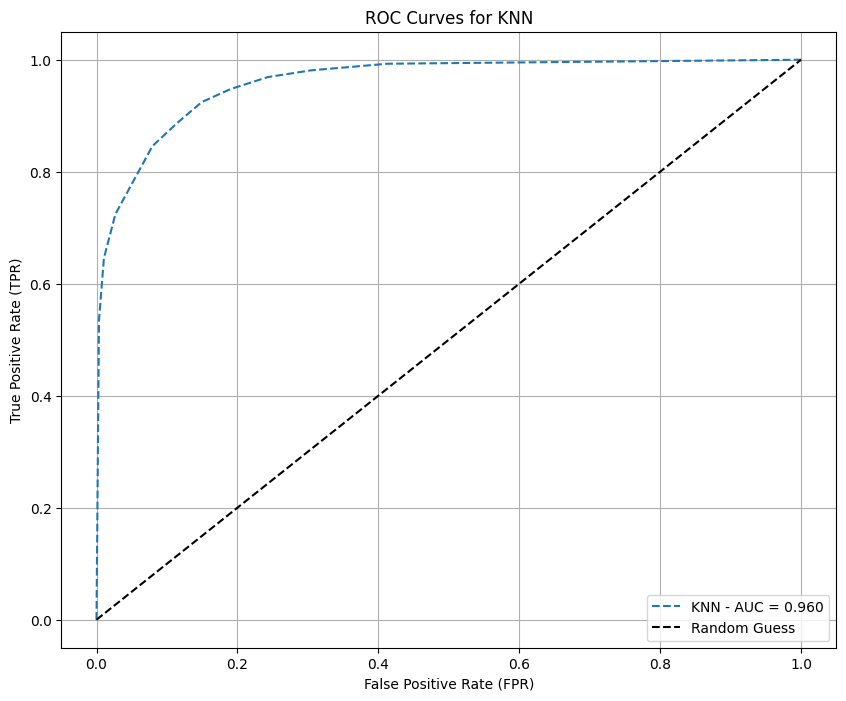

KNN AUC: 0.960


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Veri setini yükleme
data = pd.read_csv('/content/drive/MyDrive/ÖrüntüDers/diabetes_new.csv')
data = data.drop('Unnamed: 0', axis=1)  # Unnamed: 0 sütununu kaldırma

# Özellikler ve hedef değişken
X = data.drop('diabetes', axis=1)
y = data['diabetes'].astype('int64')

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# En iyi parametrelerle KNN modelini oluşturma
knn_best_params = {
    'weights': 'uniform',
    'p': 2,
    'n_neighbors': 11,
    'n_jobs': -1,
    'metric': 'manhattan',
    'leaf_size': 40,
    'algorithm': 'kd_tree'
}
knn_model = KNeighborsClassifier(**knn_best_params)
knn_model.fit(X_train_scaled, y_train)

# En iyi parametrelerle XGBoost modelini oluşturma
xgb_best_params = {
    'verbosity': 0,
    'tree_method': 'hist',
    'subsample': 0.8,
    'scale_pos_weight': 1,
    'reg_lambda': 2,
    'reg_alpha': 0.1,
    'random_state': 42,
    'objective': 'binary:logistic',
    'num_parallel_tree': 1,
    'n_estimators': 150,
    'min_child_weight': 5,
    'max_leaves': 10,
    'max_depth': 9,
    'max_bin': 512,
    'learning_rate': 0.1,
    'grow_policy': 'depthwise',
    'gamma': 0.2,
    'eval_metric': 'logloss',
    'device': 'cpu',
    'colsample_bytree': 1.0,
    'colsample_bynode': 0.6,
    'colsample_bylevel': 1.0,
    'booster': 'dart',
    'base_score': 0.5
}


# Test seti için olasılık tahminleri
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]


# ROC eğrileri için FPR ve TPR hesaplama
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)


# AUC hesaplama
auc_knn = auc(fpr_knn, tpr_knn)


# ROC eğrilerini çizme
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, label=f'KNN - AUC = {auc_knn:.3f}', linestyle='--')


# Rastgele tahmin çizgisi
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Grafik ayarları
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# AUC skorlarını yazdırma
print(f"KNN AUC: {auc_knn:.3f}")


=== KNN Modeli (En İyi Parametreler) ===
Parametreler: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'n_jobs': -1, 'metric': 'manhattan', 'leaf_size': 20, 'algorithm': 'ball_tree'}
Test Seti Doğruluğu: 0.874447391688771
Test Seti F1 Skoru: 0.8729116945107399
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      1714
           1       0.87      0.87      0.87      1679

    accuracy                           0.87      3393
   macro avg       0.87      0.87      0.87      3393
weighted avg       0.87      0.87      0.87      3393


Karışıklık Matrisi:
 [[1504  210]
 [ 216 1463]]


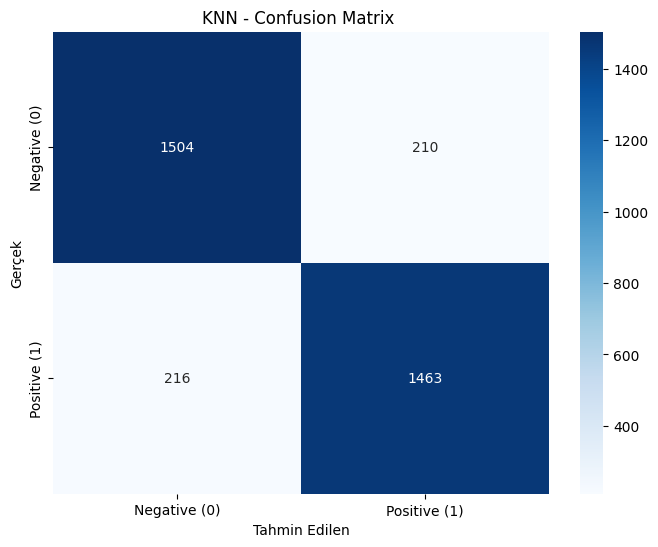

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Veri setini yükleme
data = pd.read_csv('/content/drive/MyDrive/ÖrüntüDers/diabetes_new.csv')
data = data.drop('Unnamed: 0', axis=1)  # Unnamed: 0 sütununu kaldırma

# Özellikler ve hedef değişken
X = data.drop('diabetes', axis=1)
y = data['diabetes'].astype('int64')

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi ölçeklendimre
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Parametrelre
knn_best_params = {
    'weights': 'distance',
    'p': 2,
    'n_neighbors': 3,
    'n_jobs': -1,
    'metric': 'manhattan',
    'leaf_size': 20,
    'algorithm': 'ball_tree'
}

# KNN modelini oluşturma ve eğitme
knn_model = KNeighborsClassifier(**knn_best_params)
knn_model.fit(X_train_scaled, y_train)

# Test setinde tahmin yapma
y_pred_knn = knn_model.predict(X_test_scaled)

# Sonuçları yazdırma
print("=== KNN Modeli (En İyi Parametreler) ===")
print("Parametreler:", knn_best_params)
print("Test Seti Doğruluğu:", accuracy_score(y_test, y_pred_knn))
print("Test Seti F1 Skoru:", f1_score(y_test, y_pred_knn, pos_label=1))
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_knn))

# Karışıklık Matrisi
cm = confusion_matrix(y_test, y_pred_knn)
print("\nKarışıklık Matrisi:\n", cm)

# Karışıklık Matrisini Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.title('KNN - Confusion Matrix ')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

=== Çapraz Doğrulama (5 Katlı) ===
Doğruluk Skorları (her kat): [0.88467207 0.88872513 0.88983051 0.89425203 0.88794692]
Ortalama Doğruluk: 0.8890853313870469 ± 0.003103308501863755
F1 Skorları (her kat): [0.88638838 0.89034132 0.8917059  0.89679971 0.8897752 ]
Ortalama F1 Skoru: 0.8910021043761038 ± 0.003386323366124802

=== Test Seti Sonuçları ===
Parametreler: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11, 'n_jobs': -1, 'metric': 'manhattan', 'leaf_size': 40, 'algorithm': 'kd_tree'}
Test Seti Doğruluğu: 0.8862363689949897
Test Seti F1 Skoru: 0.8852556480380499
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1714
           1       0.88      0.89      0.89      1679

    accuracy                           0.89      3393
   macro avg       0.89      0.89      0.89      3393
weighted avg       0.89      0.89      0.89      3393


Karışıklık Matrisi:
 [[1518  196]
 [ 190 1489]]


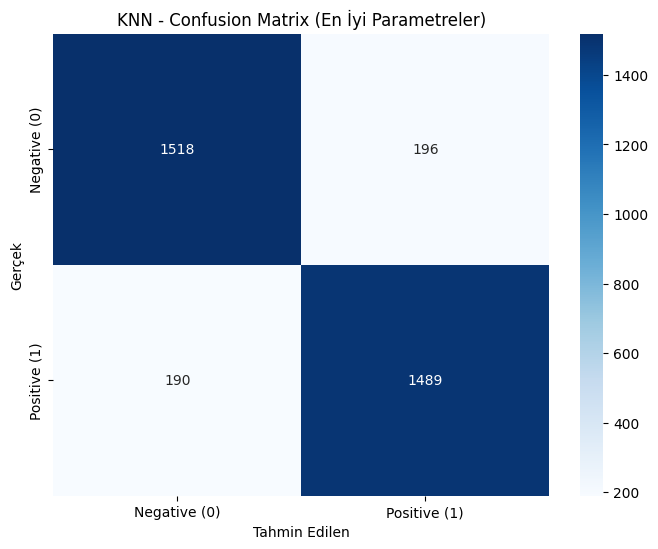

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Veri setini yükleme
data = pd.read_csv('/content/drive/MyDrive/ÖrüntüDers/diabetes_new.csv')
data = data.drop('Unnamed: 0', axis=1)  # Unnamed: 0 sütununu kaldırma

# Özellikler ve hedef değişken
X = data.drop('diabetes', axis=1)
y = data['diabetes'].astype('int64')

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# En iyi parametreler
knn_best_params = {
    'weights': 'uniform',
    'p': 2,
    'n_neighbors': 11,
    'n_jobs': -1,
    'metric': 'manhattan',
    'leaf_size': 40,
    'algorithm': 'kd_tree'
}

# KNN modelini oluşturma
knn_model = KNeighborsClassifier(**knn_best_params)

# Çapraz doğrulama (5 katlı)
print("=== Çapraz Doğrulama (5 Katlı) ===")
cv_accuracy = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_f1 = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='f1')
print("Doğruluk Skorları (her kat):", cv_accuracy)
print("Ortalama Doğruluk:", np.mean(cv_accuracy), "±", np.std(cv_accuracy))
print("F1 Skorları (her kat):", cv_f1)
print("Ortalama F1 Skoru:", np.mean(cv_f1), "±", np.std(cv_f1))

# Modeli eğitim setinde eğitme ve test setinde değerlendirme
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

# Test seti sonuçları
print("\n=== Test Seti Sonuçları ===")
print("Parametreler:", knn_best_params)
print("Test Seti Doğruluğu:", accuracy_score(y_test, y_pred_knn))
print("Test Seti F1 Skoru:", f1_score(y_test, y_pred_knn, pos_label=1))
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_knn))

# Karışıklık Matrisi
cm = confusion_matrix(y_test, y_pred_knn)
print("\nKarışıklık Matrisi:\n", cm)

# Karışıklık Matrisini Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.title('KNN - Confusion Matrix (En İyi Parametreler)')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()